In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

In [102]:
df = pd.read_csv("optionData.csv")
df = df.dropna()
stocks = df.UnderlyingSymbol.unique()
categorical_features = ["UnderlyingSymbol", "CallPut", "Side", "Exchange", "OrderEventTypeOmIn"]
for feature in categorical_features:
    df[feature] = df[feature].astype('category')
    one_hot = pd.get_dummies(df[feature])
    df = df.drop(feature, axis = 1)
    df = df.join(one_hot)
df = df.drop(stocks, axis = 1)
df = df.drop("SeInstructionId", axis = 1)
df = df.drop("OrderId", axis = 1)
df = df.drop( "OptionId", axis = 1)
df = df.drop("OptionIdOmIn", axis = 1)
df = df.drop(["Expiration", "TimeSe", "OrderEventType", "TimeOmIn", "CANCEL", "C", "B", "P", "S"], axis = 1)
def timeOfOrder(time):
    x = time.split(" ")[1].split(":")[0] + time.split(" ")[1].split(":")[1]
    x = pd.to_numeric(x)
    return x
df["TimeOfOrder"] = (df["TimeOmOut"].apply(lambda x: timeOfOrder(x)))
z = df.TimeOfOrder.unique()
for i in range(len(z)):
    df.loc[df["TimeOfOrder"] == z[i], "TimeOfOrder"] = i
df = df.drop("TimeOmOut", axis = 1)
df["Exchange"] = df["AMEX"] + 2 * df["CBOE"] + 3* df["ISE"] + 4 * df["PHLX"]
df = df.drop(["AMEX", "CBOE", "ISE", "PHLX"], axis = 1)
df

,Strike,Size,Price,MarketSize,FILL,TimeOfOrder,Exchange
0,315.0,5,10.65,10,0,0,4
1,145.0,2,2.20,72,1,0,4
2,45.0,119,8.75,499,1,0,4
3,180.0,91,29.60,210,1,0,2
4,385.0,3,68.40,27,0,0,4
...,...,...,...,...,...,...,...
29995,137.0,41,0.29,622,1,187,3
29996,720.0,58,16.15,273,1,187,4
29997,109.0,95,2.38,152,0,187,3
29998,202.0,95,1.66,186,0,187,1


In [99]:
# df1 = df[df["FILL"] == 1.0]
# df2 = df[df["FILL"] == 0.0]
# print(len(df1), len(df2))
# def balance(df, target, percentage):
#     df1 = df[df[target] == 1.0]
#     df2 = df[df[target] == 0.0]
#     # x = np.rint((1-percentage) / percentage)
#     # df2 = df2.sample(len(df1) * int(x))
#     return pd.concat([df1, df2])
# df = balance(df, "FILL", 0.67)
# df1 = df[df["FILL"] == 1.0]
# df2 = df[df["FILL"] == 0.0]
# print(len(df1), len(df2))

11640 14757
11640 0


In [103]:
def format_data(df):
    X = df.drop(['FILL'], axis = 1).to_numpy()
    y = df['FILL'].to_numpy()
    y.reshape((-1,1))
    return X, y
X,y = format_data(df)
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
#normalize the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

The shape of X is: (26397, 6)
The shape of y is: (26397,)


In [115]:
tf.random.set_seed(1234)
model = Sequential(
    [               
        tf.keras.Input(shape = (6,)),
        Dense(512, activation = "relu", name = 'L1'),
        Dense(256, activation = 'relu', name = 'L2'),
        Dense(64, activation = "relu"),
        Dense(1, activation = 'sigmoid', name = 'L3')

    ], name = "my_model" 
)
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 512)               3584      
                                                                 
 L2 (Dense)                  (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 L3 (Dense)                  (None, 1)                 65        
                                                                 
Total params: 151,425
Trainable params: 151,425
Non-trainable params: 0
_________________________________________________________________


In [116]:
def get_bce(lambda_, eps=0.01):
    def reg(y_true, y_pred):
        loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        false_pos_loss = lambda_ * tf.tensordot((tf.math.log(y_pred + eps)), float(1 - y_true), 0)
        return loss + false_pos_loss
    return reg

def lost(y_true, y_pred):
    false_pos_loss = 0.05 * tf.tensordot((tf.math.log(y_pred + 0.01)), float(1 - y_true), 0)
    return false_pos_loss

model.compile(
    loss= get_bce(0.05),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1E-3),
    metrics=["accuracy", tf.keras.metrics.Precision()]
)

history = model.fit(
    X_train,y_train, 
    validation_data=(X_val, y_val),
    epochs=30
)

Epoch 1/30
495/495 [==============================] - 2s 3ms/step - loss: 0.6484 - accuracy: 0.5935 - precision_14: 0.5807 - val_loss: 0.6384 - val_accuracy: 0.6057 - val_precision_14: 0.5656
Epoch 2/30
495/495 [==============================] - 1s 2ms/step - loss: 0.6315 - accuracy: 0.6153 - precision_14: 0.6065 - val_loss: 0.6406 - val_accuracy: 0.6042 - val_precision_14: 0.5414
Epoch 3/30
495/495 [==============================] - 1s 2ms/step - loss: 0.6276 - accuracy: 0.6220 - precision_14: 0.6079 - val_loss: 0.6336 - val_accuracy: 0.6244 - val_precision_14: 0.5762
Epoch 4/30
495/495 [==============================] - 1s 2ms/step - loss: 0.6251 - accuracy: 0.6257 - precision_14: 0.6179 - val_loss: 0.6289 - val_accuracy: 0.6178 - val_precision_14: 0.5979
Epoch 5/30
495/495 [==============================] - 1s 3ms/step - loss: 0.6251 - accuracy: 0.6246 - precision_14: 0.6181 - val_loss: 0.6272 - val_accuracy: 0.6218 - val_precision_14: 0.6157
Epoch 6/30
495/495 [====================

In [110]:
y_prediction = (model.predict(X_test) > 0.5).astype(np.float32)

#Create confusion matrix and normalizes it over predicted (columns)
x = confusion_matrix(y_test, y_prediction , normalize='pred')
print(x)

165/165 [==============================] - 0s 872us/step
[[0.63770018 0.3800136 ]
 [0.36229982 0.6199864 ]]


In [111]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

165/165 [==============================] - 0s 815us/step


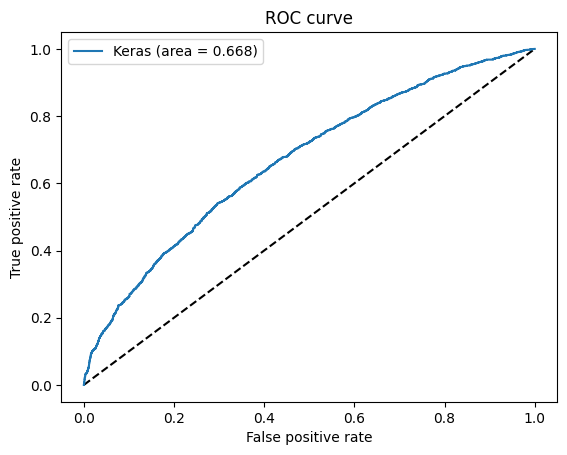

In [52]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()